**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups  # fetch_mldata заменил на fetch_openml
# функции аналогичны, fetch_mldata не поддерживается новыми версиями sklearn

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
        self.algorithm = algorithm
        self.tree = None
        self.metric = metric
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        if self.algorithm=='kd_tree':
            self.tree = KDTree((X - np.min(X)) / (np.max(X) - np.min(X)))            
    
    def predict(self, X):
        ind = np.arange(X.shape[0]).reshape(-1 ,1)
        ind = np.hstack((ind, ) * self.n_neighbors).ravel()
        if self.algorithm=='brute':
            if self.metric == 'euclidean':
                dist = euclidean_distances(X, self.X_train)
            elif self.metric == 'cosine':
                dist = 1 - cosine_similarity(X, self.X_train)
            neighb = np.argpartition(dist, self.n_neighbors, axis=1)[:, 1:self.n_neighbors+1]
            neighb = neighb[ind, np.argsort(dist[ind, neighb.ravel()].reshape(-1, self.n_neighbors), axis=1).ravel()]
            neighb = neighb.reshape(-1, self.n_neighbors)
        elif self.algorithm=='kd_tree':
            X = (X - np.min(self.X_train)) / (np.max(self.X_train) - np.min(self.X_train))
            _, neighb = self.tree.query(X, k=self.n_neighbors+1)
            neighb = np.array(neighb[:, 1:])
        y_train = np.vstack((self.y_train, ) * neighb.shape[0])
        labels = y_train[ind, neighb.ravel()].reshape(-1, self.n_neighbors)
        weights = np.arange(self.n_neighbors)[::-1].reshape(-1, 1) / self.n_neighbors
        predictions = np.vstack(tuple([((labels == i) @ weights).sum(axis=1) for i in np.unique(labels)]))
        predictions = np.argmax(predictions, axis=0)
        return predictions

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [10]:
%time clf.predict(X_test)

Wall time: 1 ms


array([0, 1, 0, 2, 1, 2, 0, 1, 2, 1, 0, 1, 0, 1, 2])

In [11]:
%time my_clf.predict(X_test)

Wall time: 1 ms


array([0, 1, 0, 2, 1, 2, 0, 1, 2, 1, 0, 1, 0, 1, 2], dtype=int32)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

Wall time: 8 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

Wall time: 1 ms


In [16]:
%time clf.predict(X_test)

Wall time: 2 ms


array([1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 0, 1, 0, 1, 0])

In [17]:
%time my_clf.predict(X_test)

Wall time: 0 ns


array([1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 0, 1, 0, 1, 0], dtype=int32)

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
data = [str (item) for item in data]

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy
vectorizer = CountVectorizer()
data_vector = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [23]:
from sklearn.model_selection import cross_validate, KFold
kf = KFold(n_splits=3)
kf.split(data_vector, target)

<generator object _BaseKFold.split at 0x1306C220>

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [24]:
def optimal_n(data_vector, target):
    scores = list()
    for n in range(1, 11):
        clf = KNeighborsClassifier(n_neighbors=n, algorithm='brute')
        score = cross_validate(clf, data_vector, target, cv=kf)
        scores.append(np.mean(score['test_score']))
    scores = np.asarray(scores)
    return scores, np.argmax(scores) + 1


scores, n = optimal_n(data_vector, target)
print(scores)
print(n)

[0.20647002 0.18357767 0.18278229 0.18163378 0.18534599 0.18340184
 0.18428562 0.18755588 0.19144498 0.19153302]
1


Text(0.5, 1.0, 'Модель с евклидовой метрикой и обычной векторизацией данных')

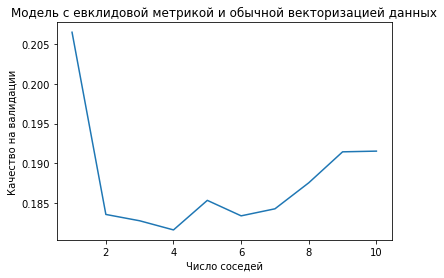

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(range(1, 11), scores)
ax1.set_xlabel("Число соседей")
ax1.set_ylabel("Качество на валидации")
ax1.set_title("Модель с евклидовой метрикой и обычной векторизацией данных")

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
def optimal_n_cos_tf_idf(data, target):
    vectorizer = TfidfVectorizer()
    data_tf_idf = vectorizer.fit_transform(data)
    scores = list()
    for n in range(1, 11):
        clf = KNeighborsClassifier(n_neighbors=n, algorithm='brute', metric='cosine')
        score = cross_validate(clf, data_tf_idf, target, cv=kf)
        scores.append(np.mean(score['test_score']))
    scores = np.asarray(scores)
    return scores, np.argmax(scores) + 1


new_scores, new_n = optimal_n_cos_tf_idf(data, target)
print(new_scores)
print(new_n)

[0.59589958 0.55691954 0.56593537 0.57115002 0.571062   0.5684986
 0.56876397 0.56690794 0.56734976 0.56752688]
1


Text(0.5, 1.0, 'Модель с косинусной метрикой и TF-IDF векторизацией данных')

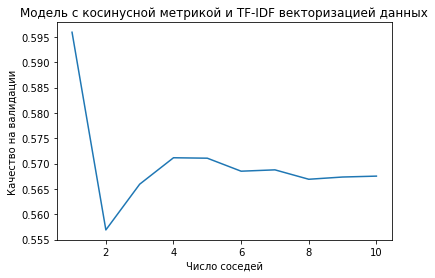

In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(range(1, 11), new_scores)
ax1.set_xlabel("Число соседей")
ax1.set_ylabel("Качество на валидации")
ax1.set_title("Модель с косинусной метрикой и TF-IDF векторизацией данных")

Очевидно, что модель с TF-IDF векторизацией и косинусной метрикой значительно лучше, чем предыдущая модель, т.к. качество на валидации улучшилось более чем в 2 раза

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [29]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.